In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from typing import Optional, Union
import warnings
from tqdm.notebook import trange
warnings.filterwarnings("ignore")

In [2]:
def _parse_target_corr(target_corr) -> list:
    """float → [r, r, r] (k=3 дефолт);  list → как есть."""
    if isinstance(target_corr, (int, float)):
        return [float(target_corr)] * 3
    return [float(x) for x in target_corr]

def generate_data(
    n: int,
    target_corr: list,
    cov_intercorr: float = 0.0,
    metric_mean: float = 100.0,
    metric_std: float = 20.0,
    cov_means: Optional[list] = None,
    cov_stds:  Optional[list] = None,
    seed: Optional[int] = 42,
    verbose: bool = False
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    r = _parse_target_corr(target_corr)
    k = len(r)

    if cov_means is None: cov_means = [0.0] * k
    if cov_stds  is None: cov_stds  = [1.0] * k
    assert len(cov_means) == k and len(cov_stds) == k

    # Корреляционная матрица (k+1)×(k+1)
    Sigma = np.full((k + 1, k + 1), cov_intercorr)
    np.fill_diagonal(Sigma, 1.0)
    Sigma[0, 1:] = r
    Sigma[1:, 0] = r

    # Гарантируем положительную определённость
    lam_min = np.linalg.eigvalsh(Sigma).min()
    if lam_min <= 1e-10:
        eps = abs(lam_min) + 1e-8
        Sigma += eps * np.eye(k + 1)
        d = np.sqrt(np.diag(Sigma))
        Sigma /= np.outer(d, d)

    L = np.linalg.cholesky(Sigma)
    Z = rng.standard_normal((n, k + 1)) @ L.T

    metric = Z[:, 0] * metric_std + metric_mean
    data   = {"metric": metric}
    for i in range(k):
        data[f"cov{i+1}"] = Z[:, i+1] * cov_stds[i] + cov_means[i]
    df = pd.DataFrame(data)

    # Диагностика
    cov_names = [f"cov{i+1}" for i in range(k)]
    r_obs     = [round(df["metric"].corr(df[c]), 3) for c in cov_names]
    rho_pairs = [df[cov_names[i]].corr(df[cov_names[j]])
                 for i in range(k) for j in range(i+1, k)]
    rho_obs   = round(float(np.mean(rho_pairs)), 3) if rho_pairs else float("nan")
    r2_mult   = LinearRegression().fit(df[cov_names].values, df["metric"].values
                                       ).score(df[cov_names].values, df["metric"].values)
    denom     = 1 + (k - 1) * cov_intercorr
    R_theor   = round(np.sqrt(k * np.mean([ri**2 for ri in r]) / denom), 3) if denom > 0 else float("nan")

    if verbose:
        print(f"[generate_data] n={n},  k={k} ковариат")
        print(f"  target_corr (цель):      {[round(ri, 3) for ri in r]}")
        print(f"  Индивидуальные r (факт): {r_obs}")
        print(f"  cov_intercorr (цель):    {round(cov_intercorr, 3)}")
        if rho_pairs:
            print(f"  Межковариатная ρ (факт): {rho_obs}  "
                  f"(пары: {[round(p, 3) for p in rho_pairs]})")
        print(f"  R множественная (факт):  {round(np.sqrt(r2_mult), 3)}  (R²={round(r2_mult, 3)})")
        print(f"  R множественная (теор.): {R_theor}")
    return df

In [3]:
def _cov_cols(df: pd.DataFrame) -> list:
    """Имена колонок-ковариат (всё кроме metric/group/metric_observed)."""
    return [c for c in df.columns if c not in {"metric", "group", "metric_observed"}]

def _ols_pval_fast(df: pd.DataFrame) -> float:
    y, n  = df["metric_observed"].values, len(df)
    trt   = (df["group"] == "treatment").astype(float).values
    names = _cov_cols(df)
    X     = np.column_stack([np.ones(n), trt] + [df[c].values for c in names])
    p     = X.shape[1]
    try:
        inv = np.linalg.inv(X.T @ X)
        b   = inv @ X.T @ y
        s2  = ((y - X @ b) @ (y - X @ b)) / (n - p)
        t   = b[1] / np.sqrt(s2 * inv[1, 1])
        return float(2 * stats.t.sf(abs(t), df=n - p))
    except np.linalg.LinAlgError:
        return 1.0

In [4]:
def plot_ecdf(df, vline=None):
    fig, ax = plt.subplots()
    
    for col in df.columns:
        sns.ecdfplot(df[col], label=col, ax=ax)
    
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set(xlabel='p-value', ylabel='Probability')
    
    if vline is not None:
        ax.axvline(vline, color='red', linestyle='--', linewidth=1, label=f'α = {vline}')
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        for i, col in enumerate(df.columns):
            ecdf_value = np.mean(df[col].values <= vline)
            ax.axhline(ecdf_value, color=colors[i % len(colors)], linestyle='--', linewidth=1,
                       label=f'power ({col}) = {ecdf_value:.3f}')
    
    ax.legend()
    plt.tight_layout()
    plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

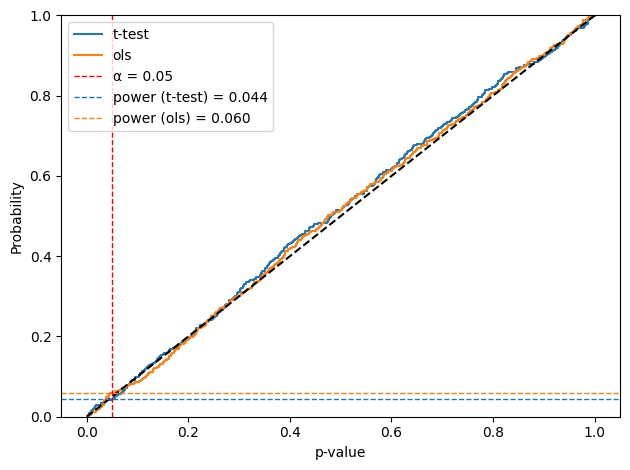

In [5]:
n_simulations = 500
n_per_group = 300
metric_std = 20.0
target_corr = [0.3, 0.5, 0.6]
cov_intercorr = 0.0
effect_size = 2.0
alpha = 0.05

n_total = n_per_group * 2
aa_s, aa_c  = [], []

for seed in trange(n_simulations):
    df_base = generate_data(n=n_total, target_corr=target_corr,
                                cov_intercorr=cov_intercorr,
                                metric_std=metric_std, seed=seed)
    rng  = np.random.default_rng(seed + 99999)
    is_t = rng.random(n_total) < 0.5

    df_aa = df_base.copy()
    df_aa["group"] = np.where(is_t, "treatment", "control")
    df_aa["metric_observed"] = df_aa["metric"]
    ctrl = df_aa.loc[df_aa["group"]=="control",   "metric_observed"].values
    trt  = df_aa.loc[df_aa["group"]=="treatment", "metric_observed"].values
    aa_s.append(stats.ttest_ind(ctrl, trt).pvalue)
    aa_c.append(_ols_pval_fast(df_aa))

df = pd.DataFrame({
    "t-test": aa_s, 
    "ols": aa_c
})


plot_ecdf(df, vline=alpha)

  0%|          | 0/500 [00:00<?, ?it/s]

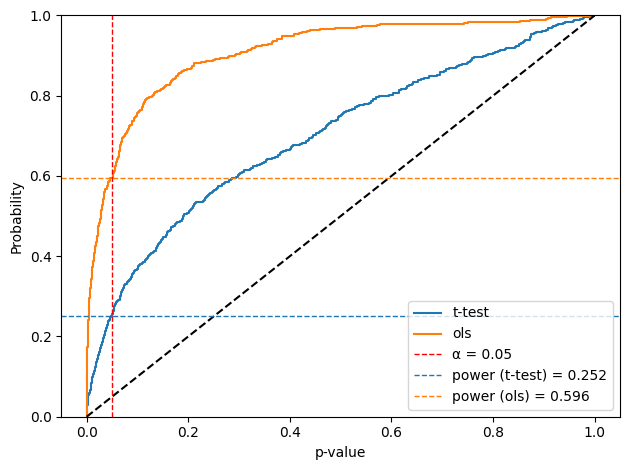

In [6]:
n_simulations = 500
n_per_group = 300
metric_std = 20.0
target_corr = [0.3, 0.5, 0.6]
cov_intercorr = 0.0
effect_size = 2.0
alpha = 0.05

n_total = n_per_group * 2
ab_s, ab_c = [], []

for seed in trange(n_simulations):
    df_base = generate_data(n=n_total, target_corr=target_corr,
                            cov_intercorr=cov_intercorr,
                            metric_std=metric_std, seed=seed)
    is_t = rng.random(n_total) < 0.5
    df_ab = df_base.copy()
    df_ab["group"] = np.where(is_t, "treatment", "control")
    df_ab["metric_observed"] = df_ab["metric"]
    df_ab.loc[df_ab["group"]=="treatment", "metric_observed"] += effect_size
    ctrl = df_ab.loc[df_ab["group"]=="control",   "metric_observed"].values
    trt  = df_ab.loc[df_ab["group"]=="treatment", "metric_observed"].values
    ab_s.append(stats.ttest_ind(ctrl, trt).pvalue)
    ab_c.append(_ols_pval_fast(df_ab))

df = pd.DataFrame({
    "t-test": ab_s, 
    "ols": ab_c
})


plot_ecdf(df, vline=alpha)